**Model 1**: Weights distributed in a way that complete similarity between two vectors is given weight zero. Aside that, the higher the similarty (lower distance) the higher the weight between two neurons.

**Model 2**: Weights distributed in a way that complete similarity and no similarity between two vectors is given weight zero. Aside that, the higher the similarty (lower distance) the lower the weight between two neurons.

**Baseline 1**: Weights connected randomly (gaussian). 

**Baseline 2**: Weights all given a weight of zero.

In [74]:
#Download Necessary packages
import torch
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

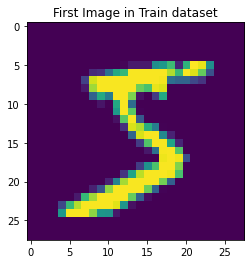

Label is 5


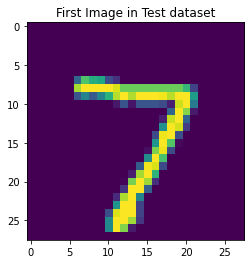

Label is 7


In [75]:
#Visualize data
data_train = datasets.MNIST(root='./data', 
                            train = True, 
                            download=True)

data_test = datasets.MNIST(root='./data',
                           train = False, 
                           download = True)

train_image = data_train[0][0]
train_image_label = data_train[0][1]

test_image = data_test[0][0]
test_image_label = data_test[0][1]

# Print the Image using Matplotlib
#Display first image in trainset
plt.title("First Image in Train dataset")
plt.imshow(train_image)
plt.show()
print('Label is', train_image_label)
#Display first image in testset
plt.title("First Image in Test dataset")
plt.imshow(test_image)
plt.show()
print('Label is', test_image_label)

In [76]:
#Download data and split into train and test images
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

#Initialize batch size
batch_size = 100

#Seprate data into batches
train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, num_workers = 4)

test_loader = DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False, num_workers = 4)

**Neural Network Architecture**

In [101]:
#Building Neural Network
class FFNN(nn.Module):
    """Simple Feed Forward Neural Network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.accuracy_function = accuracy
        
        # Create first hidden layer
        self.input_layer = nn.Linear(784, 78)
        
        # Create output layer
        self.output_layer = nn.Linear(78, 10)
       
    def forward(self, input_image):
        # Flatten image
        input_image = input_image.view(input_image.size(0), -1)
        
        # Utilize hidden layers and apply activation function
        output = self.input_layer(input_image)
        output = F.relu(output)
        
        # Get predictions
        output = self.output_layer(output)
        output = F.softmax(output, dim = 1)
        return output

    def training_step(self, batch):
        # Load batch
        images, labels = batch
        
        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def testing_step(self, batch):
        # Load batch
        images, labels = batch 

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'test_loss': loss, 'test_acc': acc}
        
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        
        # Combine losses and return mean value
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Testing Loss: {:.4f}, Testing Accuracy: {:.4f}".format(epoch, result['test_loss'], 
                                                                                  result['test_acc']))
def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()*100/ len(preds))
    
def plot_history(history):
        losses = [x['test_loss'] for x in history]
        plt.plot(losses, '-x')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        accuracies = [x['test_acc'] for x in history]
        plt.plot(accuracies, '-x')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Loss', 'Accuracy'])
        plt.title('Loss and Accuracy');
        
def list_acc(history):
    acc = [x['test_acc'] for x in history]
    return acc 

def list_loss(history):
    losses = [x['test_loss'] for x in history]
    return losses

In [102]:
#initalize epoch number
epochs  = 5

#NN trainer
class ModelTrainer():   
    def fit(self, model, train_loader, test_loader):
        history = []
        optimizer = optim.Adam(model.parameters(), lr=0.0001) 

        for epoch in range(epochs):
            # Training 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Testing
            result = self._evaluate(model, test_loader)
            model.epoch_end(epoch, result)
            history.append(result)
            
        return history

    def _evaluate(self, model, test_loader):
        outputs = [model.testing_step(batch) for batch in test_loader]
        return model.testing_epoch_end(outputs)  

**Model 1: 2 Pdch types**

In [79]:
m1_weightl2 = np.loadtxt(open("model1weightl2.txt","rb"),delimiter=",",skiprows=0)
m1_weightout = np.loadtxt(open("model1weightout.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model1 = FFNN()   

#initalize weights in input layer
weights_inputm1 = torch.tensor(m1_weightl2) 
model1.input_layer.weight.data = model1.input_layer.weight.data*0.0 + weights_inputm1

#initalize weights in output layer
weights_outputm1 = torch.tensor(m1_weightout)  
model1.output_layer.weight.data = model1.output_layer.weight.data *0.0 + weights_outputm1

model1.float()

model1_trainer = ModelTrainer()

training_historym1 = []
training_historym1 += model1_trainer.fit(model1, train_loader, test_loader)

model1_2acc = list_acc(training_historym1)
model1_2loss = list_loss(training_historym1)

Epoch: 0 - Testing Loss: 19.2791, Testing Accuracy: 20.6000
Epoch: 1 - Testing Loss: 4.2196, Testing Accuracy: 51.6600
Epoch: 2 - Testing Loss: 2.6387, Testing Accuracy: 65.9300
Epoch: 3 - Testing Loss: 1.9261, Testing Accuracy: 73.0800
Epoch: 4 - Testing Loss: 1.5217, Testing Accuracy: 77.3300


**Model 2: 2 Pdch types**

In [80]:
m2_weightl2 = np.loadtxt(open("model2weightl2.txt","rb"),delimiter=",",skiprows=0)
m2_weightout = np.loadtxt(open("model2weightout.txt","rb"),delimiter=",",skiprows=0)

#convert to float
model2 = FFNN()   

#initalize weights in input layer
weights_inputm2 = torch.tensor(m2_weightl2) 
model2.input_layer.weight.data = model2.input_layer.weight.data*0.0 + weights_inputm2

#initalize weights in output layer
weights_outputm2 = torch.tensor(m2_weightout)  
model2.output_layer.weight.data = model1.output_layer.weight.data *0.0 + weights_outputm2

model2.float()

model2_trainer = ModelTrainer()

training_historym2 = []
training_historym2 += model2_trainer.fit(model2, train_loader, test_loader)

model2_2acc = list_acc(training_historym2)
model2_2loss = list_loss(training_historym2)

Epoch: 0 - Testing Loss: 2.2853, Testing Accuracy: 47.7900
Epoch: 1 - Testing Loss: 1.1366, Testing Accuracy: 70.1200
Epoch: 2 - Testing Loss: 0.7815, Testing Accuracy: 78.5200
Epoch: 3 - Testing Loss: 0.6236, Testing Accuracy: 82.7600
Epoch: 4 - Testing Loss: 0.5369, Testing Accuracy: 85.3500


**Basline 1: Gaussian weight distribution**

In [81]:
gaussian_model = FFNN()

def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, 0, 0.0357)
            
gaussian_model.apply(init_normal)           
            
model_trainer = ModelTrainer()

model_trainer = ModelTrainer()

training_history = []
training_history += model_trainer.fit(gaussian_model, train_loader, test_loader)

gaussian_acc = list_acc(training_history)
gaussian_loss = list_loss(training_history)


Epoch: 0 - Testing Loss: 0.6657, Testing Accuracy: 85.9700
Epoch: 1 - Testing Loss: 0.4173, Testing Accuracy: 89.5300
Epoch: 2 - Testing Loss: 0.3465, Testing Accuracy: 90.8300
Epoch: 3 - Testing Loss: 0.3144, Testing Accuracy: 91.4100
Epoch: 4 - Testing Loss: 0.2941, Testing Accuracy: 91.7400


**Basline 2: Non random weight distribution**

In [82]:
nonrandom_model = FFNN()

def init_constant(m):
        if type(m) == nn.Linear:
            nn.init.constant_(m.weight, 1)
            
nonrandom_model.apply(init_constant)           
            
model_trainer2 = ModelTrainer()

training_history2 = []
training_history2 += model_trainer2.fit(nonrandom_model, train_loader, test_loader)

nonrandom_acc = list_acc(training_history2)
nonrandom_loss = list_loss(training_history2)

Epoch: 0 - Testing Loss: 2.3396, Testing Accuracy: 9.7400
Epoch: 1 - Testing Loss: 2.0073, Testing Accuracy: 27.3100
Epoch: 2 - Testing Loss: 1.5969, Testing Accuracy: 42.6000
Epoch: 3 - Testing Loss: 1.3374, Testing Accuracy: 51.5500
Epoch: 4 - Testing Loss: 1.1770, Testing Accuracy: 57.5600


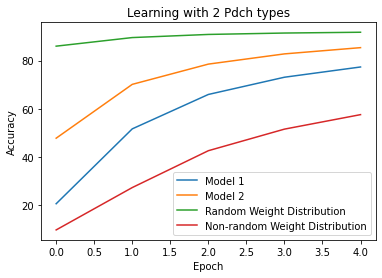

In [83]:
plt.plot(model1_2acc, label = "Model 1")
plt.plot(model2_2acc, label = "Model 2")
plt.plot(gaussian_acc, label = "Random Weight Distribution")
plt.plot(nonrandom_acc, label = "Non-random Weight Distribution")
plt.title('Learning with 2 Pdch types')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Model 1: 3 Pdch**

In [84]:
m1p3_weightl2 = np.loadtxt(open("model1weightl2_3.txt","rb"),delimiter=",",skiprows=0)
m1p3_weightout = np.loadtxt(open("model1weightout_3.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model1p3 = FFNN()   

#initalize weights in input layer
weights_inputm1p3 = torch.tensor(m1p3_weightl2) 
model1p3.input_layer.weight.data = model1p3.input_layer.weight.data*0.0 + weights_inputm1p3

#initalize weights in output layer
weights_outputm1p3 = torch.tensor(m1p3_weightout)  
model1p3.output_layer.weight.data = model1p3.output_layer.weight.data *0.0 + weights_outputm1p3

model1p3.float()

model1p3_trainer = ModelTrainer()

training_historym1p3 = []
training_historym1p3 += model1p3_trainer.fit(model1p3, train_loader, test_loader)

model1_3acc = list_acc(training_historym1p3)
model1_3loss = list_loss(training_historym1p3)

Epoch: 0 - Testing Loss: 15.8895, Testing Accuracy: 27.2500
Epoch: 1 - Testing Loss: 3.5167, Testing Accuracy: 53.1100
Epoch: 2 - Testing Loss: 1.6730, Testing Accuracy: 68.5700
Epoch: 3 - Testing Loss: 1.2090, Testing Accuracy: 74.9800
Epoch: 4 - Testing Loss: 0.9577, Testing Accuracy: 79.3200


**Model 2: 3 Pdch**

In [85]:
m2p3_weightl2 = np.loadtxt(open("model2weightl2_3.txt","rb"),delimiter=",",skiprows=0)
m2p3_weightout = np.loadtxt(open("model2weightout_3.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model2p3 = FFNN()   

#initalize weights in input layer
weights_inputm2p3 = torch.tensor(m2p3_weightl2) 
model2p3.input_layer.weight.data = model2p3.input_layer.weight.data*0.0 + weights_inputm2p3

#initalize weights in output layer
weights_outputm2p3 = torch.tensor(m2p3_weightout)  
model2p3.output_layer.weight.data = model2p3.output_layer.weight.data *0.0 + weights_outputm2p3

model2p3.float()

model2p3_trainer = ModelTrainer()

training_historym2p3 = []
training_historym2p3 += model2p3_trainer.fit(model2p3, train_loader, test_loader)

model2_3acc = list_acc(training_historym2p3)
model2_3loss = list_loss(training_historym2p3)

Epoch: 0 - Testing Loss: 3.7757, Testing Accuracy: 24.7200
Epoch: 1 - Testing Loss: 1.6787, Testing Accuracy: 55.3800
Epoch: 2 - Testing Loss: 0.9937, Testing Accuracy: 71.7800
Epoch: 3 - Testing Loss: 0.7168, Testing Accuracy: 79.0900
Epoch: 4 - Testing Loss: 0.5763, Testing Accuracy: 83.7000


**Model 1: 6 Pdch**

In [86]:
m1p6_weightl2 = np.loadtxt(open("model1weightl2_6.txt","rb"),delimiter=",",skiprows=0)
m1p6_weightout = np.loadtxt(open("model1weightout_6.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model1p6 = FFNN()   

#initalize weights in input layer
weights_inputm1p6 = torch.tensor(m1p6_weightl2) 
model1p6.input_layer.weight.data = model1p6.input_layer.weight.data*0.0 + weights_inputm1p6

#initalize weights in output layer
weights_outputm1p6 = torch.tensor(m1p6_weightout)  
model1p6.output_layer.weight.data = model1p6.output_layer.weight.data *0.0 + weights_outputm1p6

model1p6.float()

model1p6_trainer = ModelTrainer()

training_historym1p6 = []
training_historym1p6 += model1p6_trainer.fit(model1p6, train_loader, test_loader)

model1_6acc = list_acc(training_historym1p6)
model1_6loss = list_loss(training_historym1p6)

Epoch: 0 - Testing Loss: 5.0430, Testing Accuracy: 46.1900
Epoch: 1 - Testing Loss: 0.9859, Testing Accuracy: 71.4100
Epoch: 2 - Testing Loss: 0.7179, Testing Accuracy: 79.5000
Epoch: 3 - Testing Loss: 0.5926, Testing Accuracy: 83.0500
Epoch: 4 - Testing Loss: 0.5149, Testing Accuracy: 85.4300


**Model 2: 6 Pdch**

In [87]:
m2p6_weightl2 = np.loadtxt(open("model2weightl2_6.txt","rb"),delimiter=",",skiprows=0)
m2p6_weightout = np.loadtxt(open("model2weightout_6.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model2p6 = FFNN()   

#initalize weights in input layer
weights_inputm2p6 = torch.tensor(m2p6_weightl2) 
model2p6.input_layer.weight.data = model2p6.input_layer.weight.data*0.0 + weights_inputm2p6

#initalize weights in output layer
weights_outputm2p6 = torch.tensor(m2p6_weightout)  
model2p6.output_layer.weight.data = model2p6.output_layer.weight.data *0.0 + weights_outputm2p6

model2p6.float()

model2p6_trainer = ModelTrainer()

training_historym2p6 = []
training_historym2p6 += model2p6_trainer.fit(model2p6, train_loader, test_loader)

model2_6acc = list_acc(training_historym2p6)
model2_6loss = list_loss(training_historym2p6)

Epoch: 0 - Testing Loss: 1.3157, Testing Accuracy: 60.9200
Epoch: 1 - Testing Loss: 0.7361, Testing Accuracy: 77.5500
Epoch: 2 - Testing Loss: 0.5439, Testing Accuracy: 83.7400
Epoch: 3 - Testing Loss: 0.4542, Testing Accuracy: 86.6400
Epoch: 4 - Testing Loss: 0.3990, Testing Accuracy: 88.3100


**Model 1: 9 Pdch**

In [88]:
m1p9_weightl2 = np.loadtxt(open("model1weightl2_9.txt","rb"),delimiter=",",skiprows=0)
m1p9_weightout = np.loadtxt(open("model1weightout_9.txt","rb"),delimiter=",",skiprows=0)

model1p9 = FFNN()   

#initalize weights in input layer
weights_inputm1p9 = torch.tensor(m1p9_weightl2) 
model1p9.input_layer.weight.data = model1p9.input_layer.weight.data*0.0 + weights_inputm1p9

#initalize weights in output layer
weights_outputm1p9 = torch.tensor(m1p9_weightout)  
model1p9.output_layer.weight.data = model1p9.output_layer.weight.data *0.0 + weights_outputm1p9

model1p9.float()

model1p9_trainer = ModelTrainer()

training_historym1p9 = []
training_historym1p9 += model1p9_trainer.fit(model1p9, train_loader, test_loader)

model1_9acc = list_acc(training_historym1p9)
model1_9loss = list_loss(training_historym1p9)

Epoch: 0 - Testing Loss: 7.5051, Testing Accuracy: 30.5200
Epoch: 1 - Testing Loss: 1.2708, Testing Accuracy: 64.3500
Epoch: 2 - Testing Loss: 0.8255, Testing Accuracy: 75.8700
Epoch: 3 - Testing Loss: 0.6637, Testing Accuracy: 80.3900
Epoch: 4 - Testing Loss: 0.5669, Testing Accuracy: 83.5500


**Model 2: 9 Pdch**

In [89]:
m2p9_weightl2 = np.loadtxt(open("model2weightl2_9.txt","rb"),delimiter=",",skiprows=0)
m2p9_weightout = np.loadtxt(open("model2weightout_9.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model2p9 = FFNN()   

#initalize weights in input layer
weights_inputm2p9 = torch.tensor(m2p9_weightl2) 
model2p9.input_layer.weight.data = model2p9.input_layer.weight.data*0.0 + weights_inputm2p9

#initalize weights in output layer
weights_outputm2p9 = torch.tensor(m2p9_weightout)  
model2p9.output_layer.weight.data = model2p9.output_layer.weight.data *0.0 + weights_outputm2p9

model2p9.float()

model2p9_trainer = ModelTrainer()

training_historym2p9 = []
training_historym2p9 += model2p9_trainer.fit(model2p9, train_loader, test_loader)

model2_9acc = list_acc(training_historym2p9)
model2_9loss = list_loss(training_historym2p9)

Epoch: 0 - Testing Loss: 2.3675, Testing Accuracy: 51.0500
Epoch: 1 - Testing Loss: 1.1962, Testing Accuracy: 71.0700
Epoch: 2 - Testing Loss: 0.8095, Testing Accuracy: 78.9000
Epoch: 3 - Testing Loss: 0.6366, Testing Accuracy: 83.5600
Epoch: 4 - Testing Loss: 0.5399, Testing Accuracy: 85.9000


**Model 1: 12 Pdch**

In [90]:
m1p12_weightl2 = np.loadtxt(open("model1weightl2_12.txt","rb"),delimiter=",",skiprows=0)
m1p12_weightout = np.loadtxt(open("model1weightout_12.txt","rb"),delimiter=",",skiprows=0)

model1p12 = FFNN()   

#initalize weights in input layer
weights_inputm1p12 = torch.tensor(m1p12_weightl2) 
model1p12.input_layer.weight.data = model1p12.input_layer.weight.data*0.0 + weights_inputm1p12

#initalize weights in output layer
weights_outputm1p12 = torch.tensor(m1p12_weightout)  
model1p12.output_layer.weight.data = model1p12.output_layer.weight.data *0.0 + weights_outputm1p12

model1p12.float()

model1p12_trainer = ModelTrainer()

training_historym1p12 = []
training_historym1p12 += model1p12_trainer.fit(model1p12, train_loader, test_loader)

model1_12acc = list_acc(training_historym1p12)
model1_12loss = list_loss(training_historym1p12)

Epoch: 0 - Testing Loss: 5.0689, Testing Accuracy: 46.0400
Epoch: 1 - Testing Loss: 0.8963, Testing Accuracy: 72.3500
Epoch: 2 - Testing Loss: 0.6536, Testing Accuracy: 80.4000
Epoch: 3 - Testing Loss: 0.5433, Testing Accuracy: 83.9700
Epoch: 4 - Testing Loss: 0.4787, Testing Accuracy: 85.9100


**Model 2: 12 Pdch**

In [91]:
m2p12_weightl2 = np.loadtxt(open("model2weightl2_12.txt","rb"),delimiter=",",skiprows=0)
m2p12_weightout = np.loadtxt(open("model2weightout_12.txt","rb"),delimiter=",",skiprows=0)
#convert to float
model2p12 = FFNN()   

#initalize weights in input layer
weights_inputm2p12 = torch.tensor(m2p12_weightl2) 
model2p12.input_layer.weight.data = model2p12.input_layer.weight.data*0.0 + weights_inputm2p12

#initalize weights in output layer
weights_outputm2p12 = torch.tensor(m2p12_weightout)  
model2p12.output_layer.weight.data = model2p12.output_layer.weight.data *0.0 + weights_outputm2p12

model2p12.float()

model2p12_trainer = ModelTrainer()

training_historym2p12 = []
training_historym2p12 += model2p9_trainer.fit(model2p12, train_loader, test_loader)

model2_12acc = list_acc(training_historym2p12)
model2_12loss = list_loss(training_historym2p12)

Epoch: 0 - Testing Loss: 1.3931, Testing Accuracy: 60.1700
Epoch: 1 - Testing Loss: 0.7112, Testing Accuracy: 77.9300
Epoch: 2 - Testing Loss: 0.5183, Testing Accuracy: 84.2900
Epoch: 3 - Testing Loss: 0.4310, Testing Accuracy: 87.1900
Epoch: 4 - Testing Loss: 0.3828, Testing Accuracy: 88.7400


**Model 1: 15 Pdch**

In [92]:
m1p15_weightl2 = np.loadtxt(open("model1weightl2_15.txt","rb"),delimiter=",",skiprows=0)
m1p15_weightout = np.loadtxt(open("model1weightout_15.txt","rb"),delimiter=",",skiprows=0)

model1p15 = FFNN()   

#initalize weights in input layer
weights_inputm1p15 = torch.tensor(m1p15_weightl2) 
model1p15.input_layer.weight.data = model1p15.input_layer.weight.data*0.0 + weights_inputm1p15

#initalize weights in output layer
weights_outputm1p15 = torch.tensor(m1p15_weightout)  
model1p15.output_layer.weight.data = model1p15.output_layer.weight.data *0.0 + weights_outputm1p15

model1p15.float()

model1p15_trainer = ModelTrainer()

training_historym1p15 = []
training_historym1p15 += model1p15_trainer.fit(model1p15, train_loader, test_loader)

model1_15acc = list_acc(training_historym1p15)
model1_15loss = list_loss(training_historym1p15)

Epoch: 0 - Testing Loss: 2.7882, Testing Accuracy: 38.3900
Epoch: 1 - Testing Loss: 1.1208, Testing Accuracy: 66.3600
Epoch: 2 - Testing Loss: 0.7514, Testing Accuracy: 77.3300
Epoch: 3 - Testing Loss: 0.5945, Testing Accuracy: 82.2900
Epoch: 4 - Testing Loss: 0.5094, Testing Accuracy: 84.9200


**Model 2: 15 Pdch**

In [94]:
m2p15_weightl2 = np.loadtxt(open("model2weightl2_15.txt","rb"),delimiter=",",skiprows=0)
m2p15_weightout = np.loadtxt(open("model2weightout_15.txt","rb"),delimiter=",",skiprows=0)

model2p15 = FFNN()   

#initalize weights in input layer
weights_inputm2p15 = torch.tensor(m2p15_weightl2) 
model2p15.input_layer.weight.data = model2p15.input_layer.weight.data*0.0 + weights_inputm2p15

#initalize weights in output layer
weights_outputm2p15 = torch.tensor(m2p15_weightout)  
model2p15.output_layer.weight.data = model2p15.output_layer.weight.data *0.0 + weights_outputm2p15

model2p15.float()

model2p15_trainer = ModelTrainer()

training_historym2p15 = []
training_historym2p15 += model2p15_trainer.fit(model2p15, train_loader, test_loader)

model2_15acc = list_acc(training_historym2p15)
model2_15loss = list_loss(training_historym2p15)

Epoch: 0 - Testing Loss: 3.3499, Testing Accuracy: 40.6000
Epoch: 1 - Testing Loss: 1.5476, Testing Accuracy: 63.2800
Epoch: 2 - Testing Loss: 0.9852, Testing Accuracy: 74.1700
Epoch: 3 - Testing Loss: 0.7424, Testing Accuracy: 79.7900
Epoch: 4 - Testing Loss: 0.6158, Testing Accuracy: 83.1700


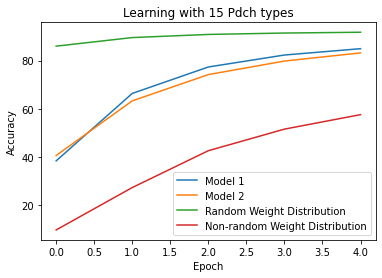

In [95]:
plt.plot(model1_15acc, label = "Model 1")
plt.plot(model2_15acc, label = "Model 2")
plt.plot(gaussian_acc, label = "Random Weight Distribution")
plt.plot(nonrandom_acc, label = "Non-random Weight Distribution")
plt.title('Learning with 15 Pdch types')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

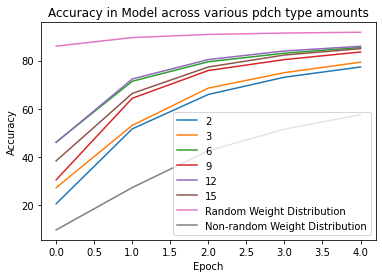

In [97]:
plt.plot(model1_2acc, label = "2")
plt.plot(model1_3acc, label = "3")
plt.plot(model1_6acc, label = "6")
plt.plot(model1_9acc, label = "9")
plt.plot(model1_12acc, label = "12")
plt.plot(model1_15acc, label = "15")
plt.plot(gaussian_acc, label = "Random Weight Distribution")
plt.plot(nonrandom_acc, label = "Non-random Weight Distribution")
plt.title('Accuracy in Model 1 across various pdch type amounts')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

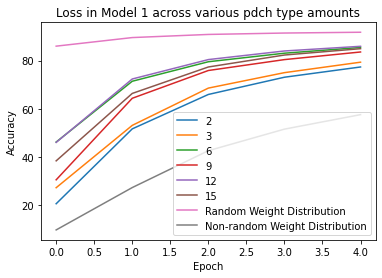

In [100]:
plt.plot(model1_2loss, label = "2")
plt.plot(model1_3loss, label = "3")
plt.plot(model1_6loss, label = "6")
plt.plot(model1_9loss, label = "9")
plt.plot(model1_12loss, label = "12")
plt.plot(model1_15loss, label = "15")
plt.plot(gaussian_loss, label = "Random Weight Distribution")
plt.plot(nonrandom_loss, label = "Non-random Weight Distribution")
plt.title('Loss in Model 1 across various pdch type amounts')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

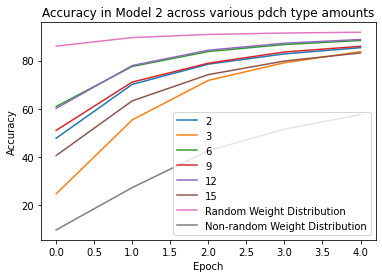

In [98]:
plt.plot(model2_2acc, label = "2")
plt.plot(model2_3acc, label = "3")
plt.plot(model2_6acc, label = "6")
plt.plot(model2_9acc, label = "9")
plt.plot(model2_12acc, label = "12")
plt.plot(model2_15acc, label = "15")
plt.plot(gaussian_acc, label = "Random Weight Distribution")
plt.plot(nonrandom_acc, label = "Non-random Weight Distribution")
plt.title('Accuracy in Model 2 across various pdch type amounts')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()